## Imports

In [1]:
import xarray as xr

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

## Open the data

In [3]:
# data in persistent bucket
target_url = 'gs://leap-persistent/tomnicholas/hero-calc/compute/llc4320/vort_strain_div_histogram_coarsen_nan_padding_3_hourly.zarr'

In [4]:
hist_ds = xr.open_dataset(target_url, engine="zarr", chunks={})

In [5]:
hist_ds['histogram_vort_strain_div'].isel(time=0).nbytes / 1e9

1.682792496

In [6]:
from xarray.indexes import PandasIndex

# have to add the index ourselves manually for some reason
hist_ds = hist_ds.set_xindex('region_num', PandasIndex)

## Correct PDF normalization

Division by 80 comes from 8 samples per day (3-hourly sampling of hourly data) over a 10-day period. 
This correction is currently required because I accidentally did `coarsen(time=8*10).sum(dim='time')` instead of `coarsen(time=8*10).mean(dim='time')` before saving to zarr.

In [7]:
hist_ds['histogram_vort_strain_div'] = hist_ds['histogram_vort_strain_div'] / 80

In [8]:
hist_ds

<xarray.Dataset>
Dimensions:                    (div_bin: 99, region: 438, time: 37,
                                vort_bin: 99, strain_bin: 49, vertices: 4)
Coordinates:
  * div_bin                    (div_bin) float64 -4.949 -4.848 ... 4.848 4.949
    face                       (region) int64 dask.array<chunksize=(13,), meta=np.ndarray>
    i_region_coarse            (region) int64 dask.array<chunksize=(438,), meta=np.ndarray>
    j_region_coarse            (region) int64 dask.array<chunksize=(438,), meta=np.ndarray>
  * region_num                 (region) int64 4 5 6 7 13 ... 791 792 793 798 799
  * strain_bin                 (strain_bin) float64 0.05102 0.1531 ... 4.949
  * time                       (time) datetime64[ns] 2011-09-17T22:30:00 ... ...
    vertices_latitude          (vertices, region) float32 dask.array<chunksize=(4, 438), meta=np.ndarray>
    vertices_longitude         (vertices, region) float32 dask.array<chunksize=(4, 438), meta=np.ndarray>
  * vort_bin                   (vort_bin) float64 -4.949 -4.848 ... 4.848 4.949
Dimensions without coordinates: region, vertices
Data variables:
    histogram_vort_strain_div  (time, region, vort_bin, strain_bin, div_bin) float64 dask.array<chunksize=(1, 1, 99, 49, 99), meta=np.ndarray>

## Choose region

In [9]:
region_slice = {'region_num': [106, 114]}  # agulhas

In [10]:
h = hist_ds['histogram_vort_strain_div'].sel(**region_slice).mean(dim='region')

In [11]:
h

<xarray.DataArray 'histogram_vort_strain_div' (time: 37, vort_bin: 99,
                                               strain_bin: 49, div_bin: 99)>
dask.array<mean_agg-aggregate, shape=(37, 99, 49, 99), dtype=float64, chunksize=(1, 99, 49, 99), chunktype=numpy.ndarray>
Coordinates:
  * div_bin     (div_bin) float64 -4.949 -4.848 -4.747 ... 4.747 4.848 4.949
  * strain_bin  (strain_bin) float64 0.05102 0.1531 0.2551 ... 4.745 4.847 4.949
  * time        (time) datetime64[ns] 2011-09-17T22:30:00 ... 2012-09-11T22:3...
  * vort_bin    (vort_bin) float64 -4.949 -4.848 -4.747 ... 4.747 4.848 4.949

## Check PDF normalization

In [18]:
def integrated_probability(h_density):
    bin_volumes = h_density.coords['vort_bin'].diff('vort_bin')[0] * h_density.coords['strain_bin'].diff('strain_bin')[0] * h_density.coords['div_bin'].diff('div_bin')[0]
    
    integrated_probability = (h_density.fillna(0) * bin_volumes).sum(dim=['vort_bin', 'strain_bin', 'div_bin'])
    
    return integrated_probability

In [17]:
#integrated_probability = (h.fillna(0) * bin_volumes).sum(dim=['vort_bin', 'strain_bin', 'div_bin'])

NameError: name 'bin_volumes' is not defined

In [91]:
print(integrated_probability.max().values)
print(integrated_probability.min().values)

1.0027186546786286
1.0005884440402604


### Plot region location

In [94]:
local_ds = hist_ds.sel(**region_slice)
local_ds

<xarray.Dataset>
Dimensions:                    (div_bin: 99, region: 2, time: 37, vort_bin: 99,
                                strain_bin: 49, vertices: 4)
Coordinates:
  * div_bin                    (div_bin) float64 -4.949 -4.848 ... 4.848 4.949
    face                       (region) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    i_region_coarse            (region) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    j_region_coarse            (region) int64 dask.array<chunksize=(2,), meta=np.ndarray>
  * region_num                 (region) int64 106 114
  * strain_bin                 (strain_bin) float64 0.05102 0.1531 ... 4.949
  * time                       (time) datetime64[ns] 2011-09-17T22:30:00 ... ...
    vertices_latitude          (vertices, region) float32 dask.array<chunksize=(4, 2), meta=np.ndarray>
    vertices_longitude         (vertices, region) float32 dask.array<chunksize=(4, 2), meta=np.ndarray>
  * vort_bin                   (vort_bin) float64 -4.949 -4.848 ... 4.848 4.949
Dimensions without coordinates: region, vertices
Data variables:
    histogram_vort_strain_div  (time, region, vort_bin, strain_bin, div_bin) float64 dask.array<chunksize=(1, 1, 99, 49, 99), meta=np.ndarray>

In [99]:
vertices = local_ds[
    ['vertices_longitude', 'vertices_latitude', 'region_num']
].drop_vars(
    ['face', 'i_region_coarse', 'j_region_coarse']
)

In [100]:
vertices

<xarray.Dataset>
Dimensions:             (vertices: 4, region: 2)
Coordinates:
    vertices_longitude  (vertices, region) float32 dask.array<chunksize=(4, 2), meta=np.ndarray>
    vertices_latitude   (vertices, region) float32 dask.array<chunksize=(4, 2), meta=np.ndarray>
  * region_num          (region) int64 106 114
Dimensions without coordinates: vertices, region
Data variables:
    *empty*

In [104]:
def fix_dateline_longitude(region_vertices):
    """Sanitize longitude coordinates of a given region across the dateline"""
    
    lon = region_vertices['vertices_longitude']
    
    # check if likely a region which crosses dateline
    if (lon < -100).any() and (lon > 100).any():
        
        # add 360 to any negative longitude values
        lon[lon < 0] += 360
        
    region_vertices['vertices_longitude'] = lon
    
    return region_vertices

In [122]:
vertices = fix_dateline_longitude(vertices)

In [124]:
vertices.coords['lon_min'] = vertices.vertices_longitude.min()
vertices.coords['lon_max'] = vertices.vertices_longitude.max()
vertices.coords['lat_min'] = vertices.vertices_latitude.min()
vertices.coords['lat_max'] = vertices.vertices_latitude.max()

In [126]:
def plot_region(reg):

    import cartopy.crs as ccrs
    import matplotlib.pyplot as plt

    ax = plt.axes(projection=ccrs.PlateCarree())
    #extents = [-80, -0, -30, -90]
    
    def _bound(val, lower, upper):
        if val < lower:
            return lower
        else:
            return val
        if val > upper:
            return upper
        else:
            return val
    
    view_radius = 80
    
    extents = [
        _bound(reg.lon_min.values-view_radius, lower=-180, upper=+180),       
        _bound(reg.lon_max.values+view_radius, lower=-180, upper=+180),        
        _bound(reg.lat_min.values+view_radius, lower=-90, upper=+90),        
        _bound(reg.lat_max.values-view_radius, lower=-90, upper=+90),
    ]
    #print(extents)
    ax.set_extent(extents)
    #ax.set_global()
    ax.stock_img()


    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=2, color='black', alpha=0.2, linestyle='--', draw_labels=True)
    gl.left_labels = False
    gl.top_labels = False
    gl.right_labels=True

    # x0 x1 y0 y1 

    # lower-left to upper-left
    plt.plot([reg.lon_min.values, reg.lon_min.values], [reg.lat_min.values, reg.lat_max.values],
             color='black', linewidth=2, marker='o', #linestyle="--",
             transform=ccrs.PlateCarree(),
             )

    # lower-left to lower-right
    plt.plot([reg.lon_min.values, reg.lon_max.values], [reg.lat_min.values, reg.lat_min.values],
             color='black', linewidth=2, marker='o', #linestyle="--",
             transform=ccrs.PlateCarree(),
             )

    # upper-left to lower-right
    plt.plot([reg.lon_min.values, reg.lon_max.values], [reg.lat_max.values, reg.lat_max.values],
             color='black', linewidth=2, marker='o', #linestyle="--",
             transform=ccrs.PlateCarree(),
             )

    # upper-left to upper-right
    plt.plot([reg.lon_max.values, reg.lon_max.values], [reg.lat_min.values, reg.lat_max.values],
             color='black', linewidth=2, marker='o', #linestyle="--",
             transform=ccrs.PlateCarree(),
             )

    plt.show()

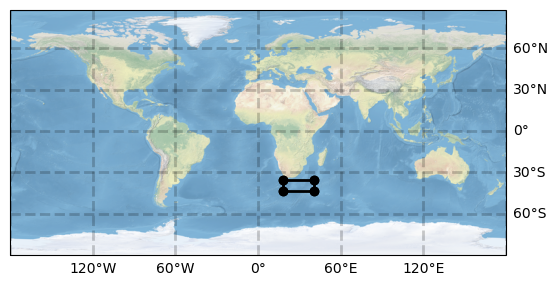

In [127]:
plot_region(vertices)

## Instantaneous vort / strain / div fields

In [128]:
import xarray as xr

In [129]:
from xarray.core.indexes import PandasIndex

In [130]:
import dask

In [131]:
import numpy as np

In [132]:
import xgcm
from typing import Annotated

In [133]:
from xhistogram.xarray import histogram as xhist_histogram

In [134]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [135]:
def open_llc4320_velocity_data(chunks='auto', time_range=None):
    
    ds_SSU = xr.open_dataset(
        "gs://pangeo-ecco-llc4320/ssu", 
        engine="zarr", 
        storage_options={'requester_pays': True}, 
        chunks=chunks, 
        inline_array=True,
        consolidated=True, 
    )
    
    ds_SSV = xr.open_dataset(
        "gs://pangeo-ecco-llc4320/ssv", 
        engine="zarr", 
        storage_options={'requester_pays': True}, 
        chunks=chunks, 
        inline_array=True,
        consolidated=True, 
    )
    
    # Open grid data
    ds_grid = xr.open_dataset(
        "gs://pangeo-ecco-llc4320/grid", 
        engine="zarr", 
        storage_options={'requester_pays': True}, 
        chunks=chunks, 
        inline_array=True,
        consolidated=True, 
    )
    
    coords_to_keep = ['XC', 'YC', 'dxC', 'dyC', 'dxG', 'dyG', 'rAz', 'rA', 'Depth']
    ds_grid = ds_grid.reset_coords()[coords_to_keep]
    
    ds = xr.merge([ds_SSU, ds_SSV, ds_grid])
    
    if time_range is not None:
        ds = ds.isel(time=time_range)
        
    ds = ds.chunk(chunks)
    
    return ds, ds_grid
    

In [136]:
ds, ds_grid = open_llc4320_velocity_data(chunks={})

In [137]:
ds

<xarray.Dataset>
Dimensions:  (time: 9030, face: 13, j: 4320, i_g: 4320, j_g: 4320, i: 4320)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
Data variables:
    U        (time, face, j, i_g) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    V        (time, face, j_g, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dxC      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyC      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dxG      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyG      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAz      (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rA       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...
    source:       MITgcm
    title:        netCDF wrapper of MITgcm MDS binary data

In [138]:
# first downsample to daily data
#ds = ds.isel(time=slice(None, None, 24)) 

In [139]:
# just a few faces and time slices for debugging
#ds = ds.isel(face=[0, 1], time=[0, 10])
#ds_grid = ds_grid.isel(face=[0, 1])

### Create xGCM grid

Only use a couple of faces and times to allow us to visualize task graph

In [140]:
#ds = ds.isel(face=slice(0,2), time=slice(0,2))
#ds_grid = ds_grid.isel(face=slice(0,2))

In [141]:
grid = xgcm.Grid(ds_grid, periodic=False)

### Define vort/strain/divergence calculation

In [142]:
def calc_f_coriolis(ds_grid):
    """Calculate the coriolis frequency for all latitudes"""
    
    lat = ds_grid['YC'].reset_coords(drop=True).rename('lat')
    
    rotation_rate = 7.2921e-5  # rad/s
    f_coriolis = (
        2 * rotation_rate * np.sin(lat*np.pi/180)
    ).rename('f_coriolis')
    
    return f_coriolis

We want to calculate the integral formula for [relative vorticity](https://mitgcm.readthedocs.io/en/latest/algorithm/algorithm.html?highlight=vorticity#relative-vorticity) in terms of circulation around a grid cell:

$$
  \zeta_3 = \frac{\Gamma}{A_\zeta} = \frac{1}{{\cal A}_\zeta} ( \delta_i \Delta y_c v - \delta_j \Delta x_c u )
$$

where $u$ and $v$ are horizontal and vertical components of surface velocity respectively.

In [143]:
@xgcm.as_grid_ufunc(
    boundary_width={"X": (1, 0), "Y": (1, 0)},
    boundary="fill",
    fill_value=np.nan,
    dask="parallelized",    
)
def vort(
    u:   Annotated[np.ndarray, "(Y:center,X:left)"],
    dxc: Annotated[np.ndarray, "(Y:center,X:left)"],
    v:   Annotated[np.ndarray, "(Y:left,X:center)"],
    dyc: Annotated[np.ndarray, "(Y:left,X:center)"],
    raz: Annotated[np.ndarray, "(Y:left,X:left)"],
) ->     Annotated[np.ndarray, "(Y:left,X:left)"]:
    """Dimensional vorticity"""
    
    u_trans = u * dxc
    v_trans = v * dyc
    v_diff_x = v_trans[..., 1:, 1:] - v_trans[..., 1:, :-1]
    u_diff_y = u_trans[..., 1:, 1:] - u_trans[..., :-1, 1:]
    return (v_diff_x - u_diff_y) / raz[..., 1:, 1:]

In [144]:
# with dask.config.set({'optimization.fuse.ave-width': 5, 'optimization.fuse.max-height': 20}):
#     graph = ζ.data.visualize(optimize_graph=True, color="order", cmap="autumn", node_attr={"penwidth": "4"})
    
# graph

In [145]:
# plot vorticity using hvplot
#ζ.isel(time=0).hvplot(x="i", y="j", rasterize=True,  width=500, height=400, cmap="RdBu_r")#, clim=(-5e-5, 5e-5))

We also want the **strain magnitude**, given by the vector magnitude of the two strain components, normal strain ($\sigma_n$) and shear strain ($\sigma_s$)

$$
\sigma = \sqrt{\sigma_n^2 + \sigma_s^2}
$$

where the components are given in terms of surface velocity components $u$ and $v$ as

$$
\sigma_n = \frac{\partial u}{\partial x} - \frac{\partial v}{\partial y}
$$
$$
\sigma_s = \frac{\partial v}{\partial x} + \frac{\partial u}{\partial y}
$$

In [146]:
@xgcm.as_grid_ufunc(
    boundary_width={"X": (1, 0), "Y": (1, 0)},
    boundary="fill",
    fill_value=np.nan,
    dask="parallelized",    
)
def strain(
    u:   Annotated[np.ndarray, "(Y:center,X:left)"],
    dxc: Annotated[np.ndarray, "(Y:center,X:left)"],
    v:   Annotated[np.ndarray, "(Y:left,X:center)"],
    dyc: Annotated[np.ndarray, "(Y:left,X:center)"],
) ->     Annotated[np.ndarray, "(Y:left,X:left)"]:
    u_diff_x = (u[..., 1:] - u[..., :-1]) / dxc[..., 1:]
    v_diff_x = (v[..., 1:] - v[..., :-1]) / dxc[..., 1:]
    u_diff_y = (u[..., 1:, :] - u[..., :-1, :]) / dyc[..., 1:, :]
    v_diff_y = (v[..., 1:, :] - v[..., :-1, :]) / dyc[..., 1:, :]
    
    u_diff_x_trimmed = u_diff_x[..., 1:, :]
    v_diff_x_trimmed = v_diff_x[..., 1:, :]
    u_diff_y_trimmed = u_diff_y[..., 1:]
    v_diff_y_trimmed = v_diff_y[..., 1:]
    
    strain_normal = u_diff_x_trimmed - v_diff_y_trimmed
    strain_shear = v_diff_x_trimmed + u_diff_y_trimmed
    
    # TODO: interpolate the shear strain onto the positions of the normal strain
    # For now, we just pretend they are at the same grid point
    strain_mag = np.sqrt(strain_normal ** 2 +  strain_shear ** 2)
    
    return strain_mag

Finally we want **divergence**, defined as


$$
D = \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y}
$$

but [represented in MITgcm](https://mitgcm.readthedocs.io/en/latest/algorithm/algorithm.html?highlight=divergence#horizontal-divergence) as 

$$
D = \frac{1}{A_c h_c} \left( \delta_i \Delta y_g h_w u + \delta_j \Delta x_g h_s v\right)
$$

In [147]:
@xgcm.as_grid_ufunc(
    boundary_width={"X": (1, 0), "Y": (1, 0)},
    boundary="fill",
    fill_value=np.nan,
    dask="parallelized",
)
def divergence(
    u:   Annotated[np.ndarray, "(Y:center,X:left)"],
    dxg: Annotated[np.ndarray, "(Y:left,X:center)"],
    v:   Annotated[np.ndarray, "(Y:left,X:center)"],
    dyg: Annotated[np.ndarray, "(Y:center,X:left)"],
    ra:  Annotated[np.ndarray, "(Y:center,X:center)"],
) ->     Annotated[np.ndarray, "(Y:center,X:center)"]:
    
    u_diff_x = (u[..., 1:] - u[..., :-1]) * dxg[..., 1:]
    v_diff_y = (v[..., 1:, :] - v[..., :-1, :]) * dyg[..., 1:, :]
    
    u_diff_x_trimmed = u_diff_x[..., 1:, :]
    v_diff_y_trimmed = v_diff_y[..., 1:]
    
    divergence = (u_diff_x_trimmed + v_diff_y_trimmed) / ra[..., 1:, 1:]
    
    return divergence

In [148]:
def calc_vort_strain_div(ds, grid):
    """Calculate normalised vorticity, strain and divergence from U and V."""
    
    # vorticity
    ζ = vort(grid, ds.U, ds.dxC, ds.V, ds.dyC, ds.rAz, axis= 5 * [("Y", "X")])
    ζ = ζ.assign_coords({"time": ds.time.values})  # TODO won't need this line once xgcm #575 is fixed
    ζ = ζ.rename({"i_g": "i", "j_g": "j"})  # pretend it's now on cell centers to match other fields
    
    # strain
    σ = strain(grid, ds.U, ds.dxC, ds.V, ds.dyC, axis=4 * [("Y", "X")])
    σ = σ.assign_coords({"time": ds.time.values})
    σ = σ.rename({"i_g": "i", "j_g": "j"})
    
    # divergence
    D = divergence(grid, ds.U, ds.dxG, ds.V, ds.dyG, ds.rA, axis= 5 * [("Y", "X")])# / abs(f_coriolis)
    D = D.assign_coords({"time": ds.time.values})
    D = D.rename("div")
    
    # Normalise
    # TODO: Would be neater to normalise inside grid ufunc but then we would also pad f unneccessarily     
    f_coriolis = calc_f_coriolis(ds_grid)
    ζ = ζ / f_coriolis
    σ = σ / abs(f_coriolis)
    D = D / abs(f_coriolis)
    
    # merge everything
    results = xr.merge(
        [
            ζ.rename("vort"),
            σ.rename("strain"),
            D.rename("div"),
            f_coriolis,
            ds_grid[['XC', 'YC', 'rA', 'Depth']]
        ]
    ).set_coords(['XC', 'YC', 'rA', 'Depth'])
    
    return results

In [149]:
results = calc_vort_strain_div(ds, grid)

In [150]:
results

<xarray.Dataset>
Dimensions:     (face: 13, i: 4320, j: 4320, time: 9030)
Coordinates:
  * face        (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i           (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j           (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time        (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
    XC          (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC          (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rA          (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
Data variables:
    vort        (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    strain      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    div         (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    f_coriolis  (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>

### Coarsen fields into regions of interest

In [151]:
def split_into_regions(results):#, vertices_longitude, vertices_latitude):
    
    regions = results.coarsen(
        i=540,
        j=540,
    ).construct(
        i=("i_region_coarse", "i_region"),
        j=("j_region_coarse", "j_region"),
    ).stack(region=['face', 'i_region_coarse', 'j_region_coarse'])
    
    #regions = regions.assign_coords(vertices_longitude=vertices_longitude, vertices_latitude=vertices_latitude)
    
    # keep a unique number for each region, and give it an index
    regions = regions.assign_coords(region_num=('region', np.arange(len(regions.region))))
    #regions = regions.set_xindex('region_num', PandasIndex)
    
    return regions

In [152]:
regions = split_into_regions(results)

In [153]:
regions

<xarray.Dataset>
Dimensions:          (i_region: 540, region: 832, j_region: 540, time: 9030)
Coordinates:
    i                (i_region, region) int64 0 0 0 0 0 ... 4319 4319 4319 4319
    j                (j_region, region) int64 0 540 1080 1620 ... 3239 3779 4319
  * time             (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
    XC               (j_region, i_region, region) float32 dask.array<chunksize=(540, 540, 64), meta=np.ndarray>
    YC               (j_region, i_region, region) float32 dask.array<chunksize=(540, 540, 64), meta=np.ndarray>
    rA               (j_region, i_region, region) float32 dask.array<chunksize=(540, 540, 64), meta=np.ndarray>
    Depth            (j_region, i_region, region) float32 dask.array<chunksize=(540, 540, 64), meta=np.ndarray>
  * region           (region) object MultiIndex
  * face             (region) int64 0 0 0 0 0 0 0 0 ... 12 12 12 12 12 12 12 12
  * i_region_coarse  (region) int64 0 0 0 0 0 0 0 0 1 1 ... 6 6 7 7 7 7 7 7 7 7
  * j_region_coarse  (region) int64 0 1 2 3 4 5 6 7 0 1 ... 6 7 0 1 2 3 4 5 6 7
    region_num       (region) int64 0 1 2 3 4 5 6 ... 826 827 828 829 830 831
Dimensions without coordinates: i_region, j_region
Data variables:
    vort             (time, j_region, i_region, region) float32 dask.array<chunksize=(1, 540, 540, 64), meta=np.ndarray>
    strain           (time, j_region, i_region, region) float32 dask.array<chunksize=(1, 540, 540, 64), meta=np.ndarray>
    div              (time, j_region, i_region, region) float32 dask.array<chunksize=(1, 540, 540, 64), meta=np.ndarray>
    f_coriolis       (j_region, i_region, region) float32 dask.array<chunksize=(540, 540, 64), meta=np.ndarray>

In [156]:
regions = regions.set_xindex('region_num', PandasIndex)

In [161]:
local_fields = regions.sel(**region_slice)
local_fields

<xarray.Dataset>
Dimensions:          (i_region: 540, region: 2, j_region: 540, time: 9030)
Coordinates:
    i                (i_region, region) int64 2700 3240 2701 ... 3778 3239 3779
    j                (j_region, region) int64 1080 1080 1081 ... 1618 1619 1619
  * time             (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
    XC               (j_region, i_region, region) float32 dask.array<chunksize=(540, 540, 2), meta=np.ndarray>
    YC               (j_region, i_region, region) float32 dask.array<chunksize=(540, 540, 2), meta=np.ndarray>
    rA               (j_region, i_region, region) float32 dask.array<chunksize=(540, 540, 2), meta=np.ndarray>
    Depth            (j_region, i_region, region) float32 dask.array<chunksize=(540, 540, 2), meta=np.ndarray>
  * region           (region) object MultiIndex
  * face             (region) int64 1 1
  * i_region_coarse  (region) int64 5 6
  * j_region_coarse  (region) int64 2 2
  * region_num       (region) int64 106 114
Dimensions without coordinates: i_region, j_region
Data variables:
    vort             (time, j_region, i_region, region) float32 dask.array<chunksize=(1, 540, 540, 2), meta=np.ndarray>
    strain           (time, j_region, i_region, region) float32 dask.array<chunksize=(1, 540, 540, 2), meta=np.ndarray>
    div              (time, j_region, i_region, region) float32 dask.array<chunksize=(1, 540, 540, 2), meta=np.ndarray>
    f_coriolis       (j_region, i_region, region) float32 dask.array<chunksize=(540, 540, 2), meta=np.ndarray>

(Just choose part of this whole region to make plotting a snapshot consistent)

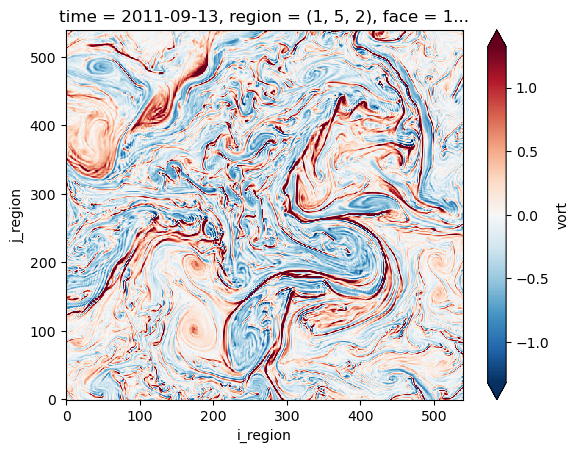

In [162]:
local_fields['vort'].isel(time=0, region=0).plot(robust=True)

/tmp/ipykernel_9926/1325305515.py:13: RuntimeWarning: invalid value encountered in divide
  u_diff_x = (u[..., 1:] - u[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_9926/1325305515.py:14: RuntimeWarning: invalid value encountered in divide
  v_diff_x = (v[..., 1:] - v[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_9926/1325305515.py:15: RuntimeWarning: invalid value encountered in divide
  u_diff_y = (u[..., 1:, :] - u[..., :-1, :]) / dyc[..., 1:, :]
/tmp/ipykernel_9926/1325305515.py:16: RuntimeWarning: invalid value encountered in divide
  v_diff_y = (v[..., 1:, :] - v[..., :-1, :]) / dyc[..., 1:, :]


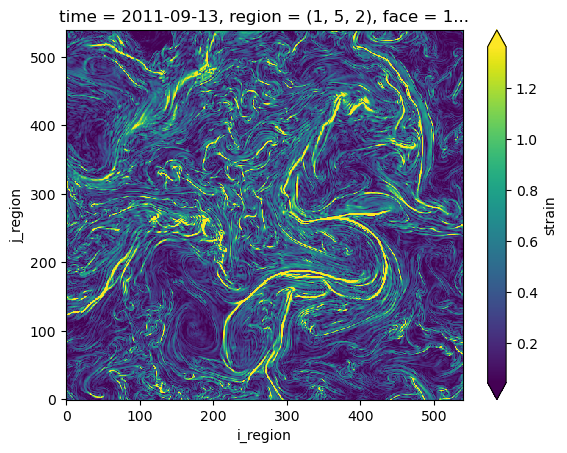

In [163]:
local_fields['strain'].isel(time=0, region=0).plot(robust=True)

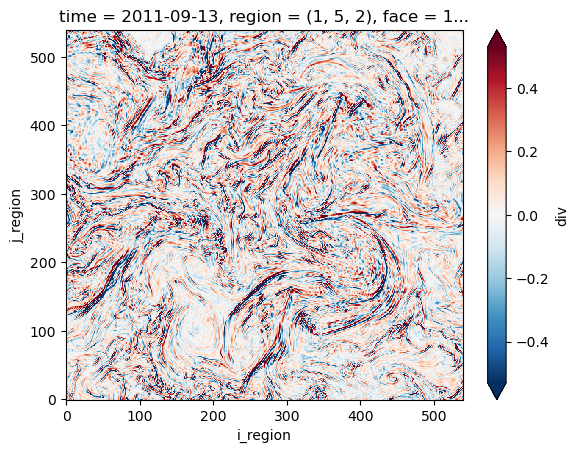

In [164]:
local_fields['div'].isel(time=0, region=0).plot(robust=True)

# Histograms

Needed to integrate out various bin dimensions whilst preserving total integrated probability

In [19]:
def marginalize(pdf: xr.DataArray, dims: str | list = None) -> xr.DataArray:
    """
    Integrate out one or more dimensions of the PDF to remove dependence on that quantity,
    whilst still preserving the total integrated probability.
    """
       
    all_bin_dims = ['vort_bin', 'strain_bin', 'div_bin']
    
    if isinstance(dims, str):
        dims = [dims]
    
    if dims is None:
        dims=all_bin_dims
    
    if any(d not in all_bin_dims for d in dims):
        raise ValueError("Can't take marginal PDF over a dimension which is not a variable of the original PDF")
    
    marginal_pdf = pdf

    # TODO these might be more accurate if we used xarray's integrate function
    if 'vort_bin' in dims:
        vort_bin_width = h['vort_bin'].diff('vort_bin')[0]
        marginal_pdf = marginal_pdf.sum(dim='vort_bin') * vort_bin_width
        
    if 'strain_bin' in dims:
        strain_bin_width = h['strain_bin'].diff('strain_bin')[0]
        marginal_pdf = marginal_pdf.sum(dim='strain_bin') * strain_bin_width
        
    if 'div_bin' in dims:
        div_bin_width = h['div_bin'].diff('div_bin')[0]
        marginal_pdf = marginal_pdf.sum(dim='div_bin') * div_bin_width
        
    return marginal_pdf


def expectation(pdf: xr.DataArray, x: xr.DataArray, dims: str | list = None) -> xr.DataArray:
    """
    Take the expectation value of x over the given Probability Density Function.
    """
    
    return marginalize(pdf * x)

In [21]:
@xr.register_dataarray_accessor("pdf")
class DataArrayPDFAccessor:
    def __init__(self, da: xr.DataArray):
        self._da = da
        
    def marginalize(self, dims: str | list = None) -> xr.DataArray:
        return marginalize(self._da, dims=dims)
    
    def expectation(self, x, dims: str | list = None) -> xr.DataArray:
        return expectation(self._da, x, dims=dims)

In [22]:
h.pdf.marginalize(dims='div_bin')

<xarray.DataArray (time: 37, vort_bin: 99, strain_bin: 49)>
dask.array<mul, shape=(37, 99, 49), dtype=float64, chunksize=(1, 99, 49), chunktype=numpy.ndarray>
Coordinates:
  * strain_bin  (strain_bin) float64 0.05102 0.1531 0.2551 ... 4.745 4.847 4.949
  * time        (time) datetime64[ns] 2011-09-17T22:30:00 ... 2012-09-11T22:3...
  * vort_bin    (vort_bin) float64 -4.949 -4.848 -4.747 ... 4.747 4.848 4.949
    div_bin     float64 -4.848

In [23]:
h.pdf.expectation(1, dims=['vort_bin', 'div_bin', 'strain_bin']).values

array([1.00078467, 1.00083128, 1.00103858, 1.00102628, 1.00136458,
       1.00137462, 1.00244988, 1.00271865, 1.00163249, 1.00109562,
       1.00159502, 1.0015997 , 1.00145005, 1.00215632, 1.00208175,
       1.00123881, 1.00104817, 1.00067321, 1.00065627, 1.00101703,
       1.00205481, 1.00106132, 1.00127299, 1.00136117, 1.00090073,
       1.00106379, 1.0010454 , 1.00122239, 1.00070341, 1.00058844,
       1.00084651, 1.00090153, 1.00084437, 1.00088871, 1.00085588,
       1.00084593, 1.00083186])

In [24]:
seasonal_hist = h.groupby("time.season").mean(dim='time')
seasonal_hist

<xarray.DataArray 'histogram_vort_strain_div' (season: 4, vort_bin: 99,
                                               strain_bin: 49, div_bin: 99)>
dask.array<transpose, shape=(4, 99, 49, 99), dtype=float64, chunksize=(1, 99, 49, 99), chunktype=numpy.ndarray>
Coordinates:
  * div_bin     (div_bin) float64 -4.949 -4.848 -4.747 ... 4.747 4.848 4.949
  * strain_bin  (strain_bin) float64 0.05102 0.1531 0.2551 ... 4.745 4.847 4.949
  * vort_bin    (vort_bin) float64 -4.949 -4.848 -4.747 ... 4.747 4.848 4.949
  * season      (season) object 'DJF' 'JJA' 'MAM' 'SON'

## 1D histograms

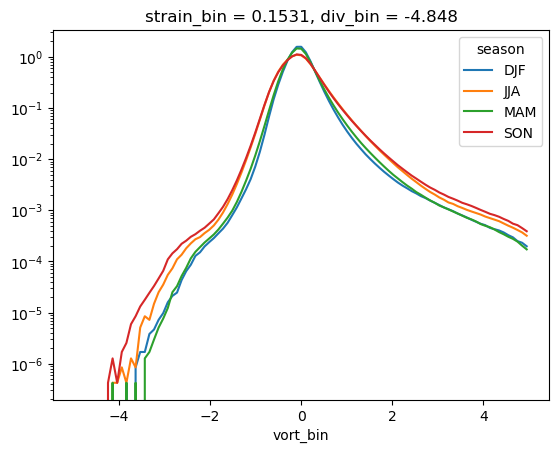

In [25]:
seasonal_hist.pdf.marginalize(['strain_bin', 'div_bin']).plot(x='vort_bin', hue='season', yscale='log')

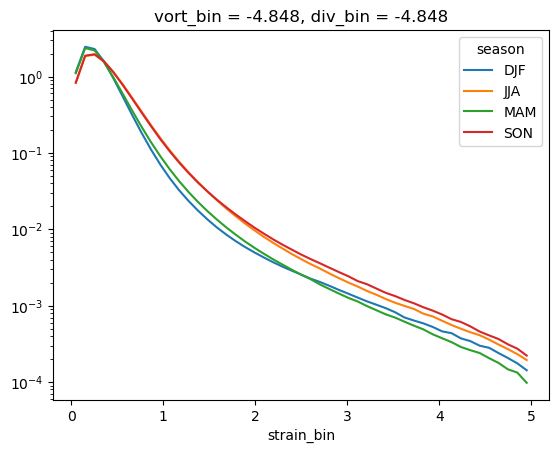

In [26]:
seasonal_hist.pdf.marginalize(['vort_bin', 'div_bin']).plot(x='strain_bin', hue='season', yscale='log')

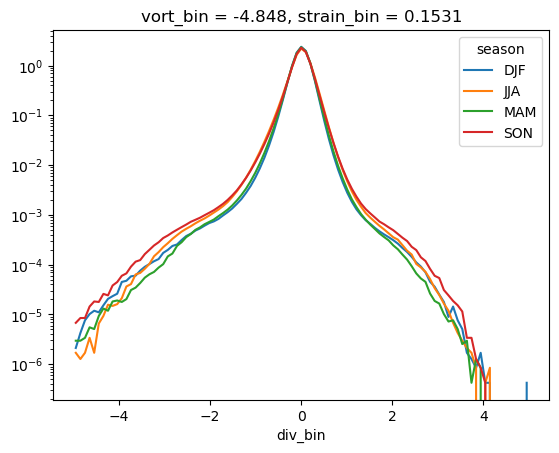

In [27]:
seasonal_hist.pdf.marginalize(['vort_bin', 'strain_bin']).plot(x='div_bin', hue='season', yscale='log')

## 2D histograms

In [21]:
def plot_vort_strain_hist(h):
    
    h = xr.where(h<1e-5, np.nan, h)  # discard values less than threshold
    
    plt.figure(figsize=(10,4.5))
    
    # plot the joint PDF
    h.plot(x="vort_bin", vmax=1e2, norm=mpl.colors.SymLogNorm(1e-4), cmap='Reds')
    
    # plot the lines of perfect correlation / anti-correlation
    strain_max = h.coords["strain_bin"].max()
    plt.plot(np.linspace(0, -strain_max, 10),np.linspace(0, strain_max, 10),'k--',alpha=.5)
    vort_max = h.coords["vort_bin"].max()
    plt.plot(np.linspace(0, vort_max), np.linspace(0, vort_max),'k--',alpha=.5)
    
    # labels
    plt.xlabel('vorticity / $f_0$')
    plt.ylabel('strain / $|f_0|$')
    
    plt.text(0, strain_max / 2, 'Front')
    plt.text(vort_max / 2, strain_max / 4, 'Cyc')
    plt.text(-vort_max / 2, strain_max / 4, 'Acyc')
    
    # grid
    plt.rc('grid', color='black', alpha=.3)
    plt.grid()

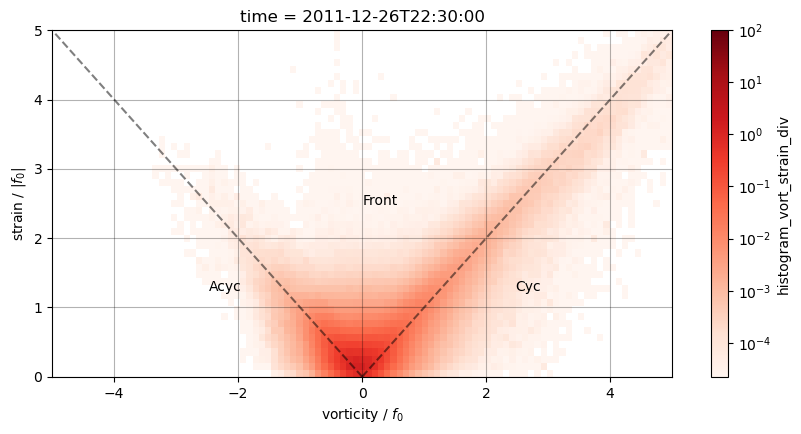

In [24]:
plot_vort_strain_hist(h.isel(time=10).mean(dim="div_bin"))

In [30]:
def plot_seasonal_vort_strain_hist(seasonal_hist):

    fig = plt.figure(figsize=(10,4.5))
    
    fg = seasonal_hist.plot(
        col="season", 
        col_wrap=2, 
        robust=True, 
        x="vort_bin",
        vmax=1e2, 
        norm=mpl.colors.SymLogNorm(1e-4), 
        cmap='Reds',
    )
  
    strain_max = seasonal_hist.coords["strain_bin"].max()
    vort_max = seasonal_hist.coords["vort_bin"].max()

    for ax, season in zip(fg.axs.flat, ["winter", "summer", "spring", "autumn"]):
        ax.plot(np.linspace(0, -strain_max, 10), np.linspace(0, strain_max, 10), 'k--', alpha=.5)
        ax.plot(np.linspace(0, vort_max), np.linspace(0, vort_max), 'k--', alpha=.5)
        #ax.set_title(season)

    # labels
    fg.set_xlabels('vorticity / $f_0$')
    fg.set_ylabels('strain / $|f_0|$')

    #plt.text(0, strain_max / 2, 'Front')
    #plt.text(vort_max / 2, strain_max / 4, 'Cyc')
    #plt.text(-vort_max / 2, strain_max / 4, 'Acyc')

    # grid
    #plt.rc('grid', color='black', alpha=.3)
    fg.map(lambda: plt.rc('grid', color='black', alpha=.3))
    fg.map(lambda: plt.grid())

<Figure size 1000x450 with 0 Axes>

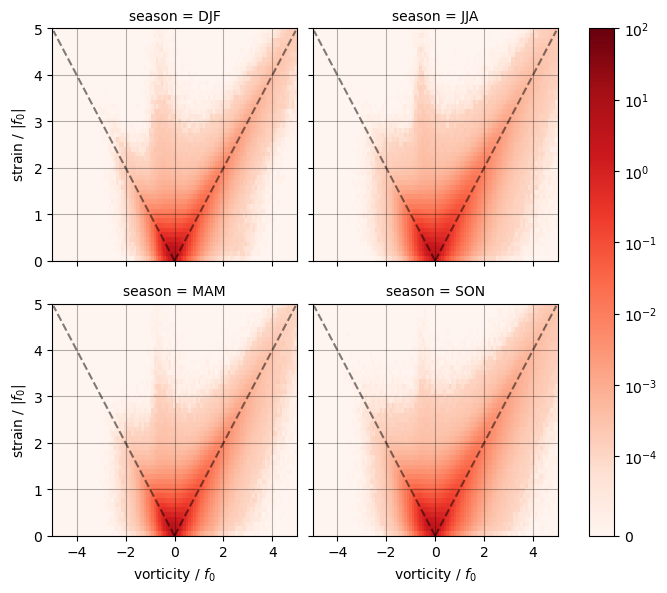

In [31]:
plot_seasonal_vort_strain_hist(seasonal_hist.pdf.marginalize('div_bin'))

In [172]:
def plot_vort_div_hist(h):
    
    h = xr.where(h<1e-5, np.nan, h)  # discard values less than threshold
    
    plt.figure(figsize=(10,4.5))
    
    # plot the joint PDF
    h.plot(x="vort_bin", vmax=1e2, norm=mpl.colors.SymLogNorm(1e-4), cmap='Reds')
    
    # plot the lines of perfect correlation / anti-correlation
    div_max = h.coords["div_bin"].max()
    #plt.plot(np.linspace(0, -strain_max, 10),np.linspace(0, strain_max, 10),'k--',alpha=.5)
    vort_max = h.coords["vort_bin"].max()
    #plt.plot(np.linspace(0, vort_max), np.linspace(0, vort_max),'k--',alpha=.5)
    
    # labels
    plt.xlabel('vorticity / $f_0$')
    plt.ylabel('div / $f_0$')
    
    #plt.text(0, div_max / 2, 'Front')
    #plt.text(vort_max / 2, div_max / 4, 'Cyc')
    #plt.text(-vort_max / 2, div_max / 4, 'Acyc')
    
    # grid
    plt.rc('grid', color='black', alpha=.3)
    plt.grid()

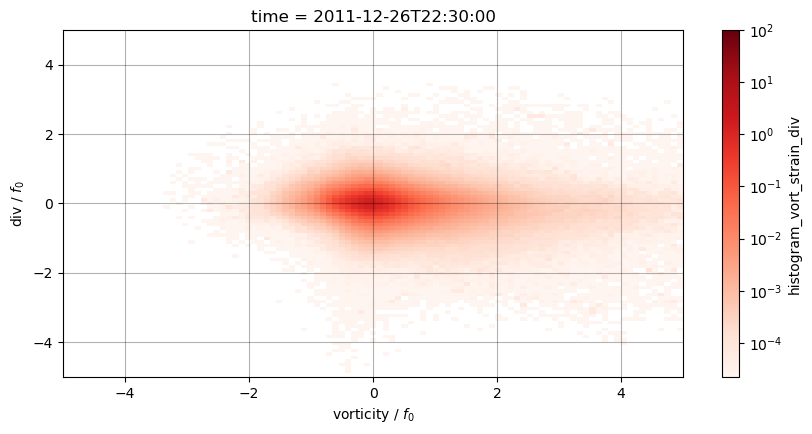

In [173]:
plot_vort_div_hist(h.isel(time=10).mean(dim="strain_bin"))

In [33]:
def plot_seasonal_vort_div_hist(seasonal_hist):

    fig = plt.figure(figsize=(10,4.5))
    
    fg = seasonal_hist.plot(
        col="season", 
        col_wrap=2, 
        robust=True, 
        x="vort_bin",
        vmax=1e2, 
        norm=mpl.colors.SymLogNorm(1e-4), 
        cmap='Reds',
    )
    
    # labels
    fg.set_xlabels('vorticity / $f_0$')
    fg.set_ylabels('div / $f_0$')

    # grid
    #plt.rc('grid', color='black', alpha=.3)
    fg.map(lambda: plt.rc('grid', color='black', alpha=.3))
    fg.map(lambda: plt.grid())

<Figure size 1000x450 with 0 Axes>

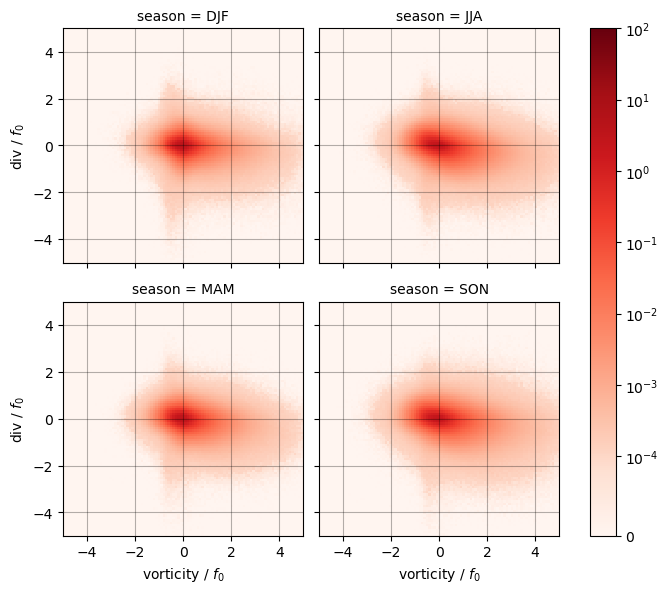

In [34]:
plot_seasonal_vort_div_hist(seasonal_hist.pdf.marginalize('strain_bin'))

In [177]:
def plot_strain_div_hist(h):
    
    h = xr.where(h<1e-5, np.nan, h)  # discard values less than threshold
    
    plt.figure(figsize=(10,4.5))
    
    # plot the joint PDF
    h.plot(x="div_bin", vmax=1e2, norm=mpl.colors.SymLogNorm(1e-4), cmap='Reds')
    
    # plot the lines of perfect correlation / anti-correlation
    strain_max = h.coords["strain_bin"].max()
    #plt.plot(np.linspace(0, -strain_max, 10),n

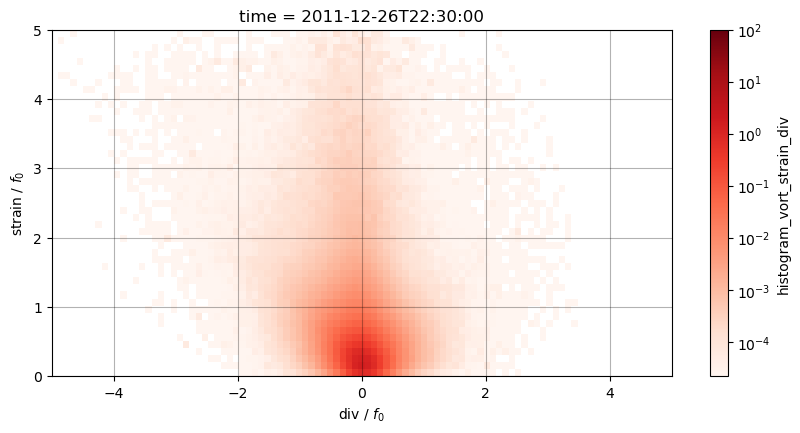

In [178]:
plot_strain_div_hist(h.isel(time=10).mean(dim="vort_bin"))

In [37]:
def plot_seasonal_strain_div_hist(seasonal_hist):

    fig = plt.figure(figsize=(10,4.5))
    
    fg = seasonal_hist.plot(
        col="season", 
        col_wrap=2, 
        robust=True, 
        x="div_bin",
        vmax=1e2, 
        norm=mpl.colors.SymLogNorm(1e-4), 
        cmap='Reds',
    )
    
    # labels
    fg.set_xlabels('vorticity / $f_0$')
    fg.set_ylabels('strain / $|f_0|$')

    # grid
    #plt.rc('grid', color='black', alpha=.3)
    fg.map(lambda: plt.rc('grid', color='black', alpha=.3))
    fg.map(lambda: plt.grid())

<Figure size 1000x450 with 0 Axes>

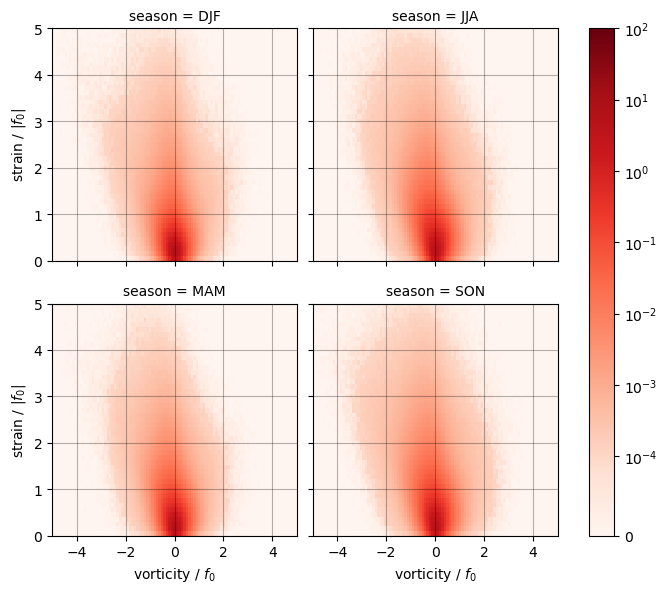

In [38]:
plot_seasonal_strain_div_hist(seasonal_hist.pdf.marginalize('vort_bin'))

## Time series of 1D statistics

In [47]:
def mean(h: xr.DataArray, x: xr.DataArray, dims: str | list = None) -> xr.DataArray:
    mu = h.pdf.expectation(x, dims)
    return mu.rename(x.name.removesuffix('_bin'))

def variance(pdf: xr.DataArray, x: xr.DataArray, dims: str | list = None) -> xr.DataArray:
    mu = mean(pdf, x, dims)
    var = h.pdf.expectation((x - mu) ** 2, dims)
    return var.rename(x.name.removesuffix('_bin'))

def standard_deviation(pdf: xr.DataArray, x: xr.DataArray, dims: str | list = None) -> xr.DataArray:
    return np.sqrt(variance(pdf, x, dims))

def skewness(pdf: xr.DataArray, x: xr.DataArray, dims: str | list = None) -> xr.DataArray:
    mu = mean(pdf, x, dims)
    sigma = standard_deviation(pdf, x, dims)
    skew = h.pdf.expectation((x - mu) ** 3, dims) / (sigma ** 3)
    return skew.rename(x.name.removesuffix('_bin'))

def kurtosis(pdf: xr.DataArray, x: xr.DataArray, dims: str | list = None) -> xr.DataArray:
    mu = mean(pdf, x, dims)
    sigma = standard_deviation(pdf, x, dims)
    kurt = h.pdf.expectation((x - mu) ** 4, dims) / (sigma ** 4) - 3
    return kurt.rename(x.name.removesuffix('_bin'))

In [45]:
"vort_bin".removesuffix('_bin')

'vort'

### Standard deviation

In [48]:
std_dev_vort = standard_deviation(h, h.vort_bin)
std_dev_strain = standard_deviation(h, h.strain_bin)
std_dev_div = standard_deviation(h, h.div_bin)

In [49]:
std_dev_vort

<xarray.DataArray 'vort' (time: 37)>
dask.array<sqrt, shape=(37,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 2011-09-17T22:30:00 ... 2012-09-11T22:3...
    vort_bin    float64 -4.848
    strain_bin  float64 0.1531
    div_bin     float64 -4.848

In [31]:
std_dev = xr.concat(
    [std_dev_vort, std_dev_strain, std_dev_div], 
    dim=xr.DataArray([std_dev_vort.name, std_dev_strain.name, std_dev_div.name], dims='variable'),
).rename('standard deviation')

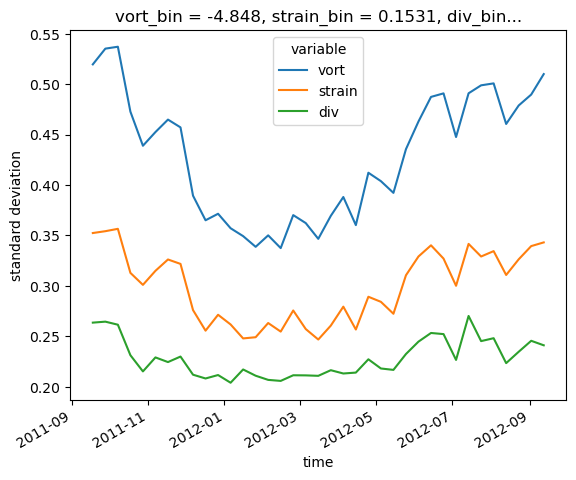

In [32]:
std_dev.plot(x='time', hue='variable')

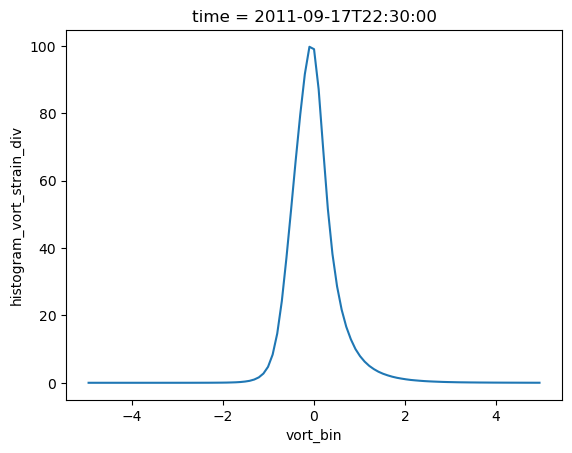

In [33]:
# sanity check
h.isel(time=0).sum(['strain_bin', 'div_bin']).plot()

### Skewness

In [36]:
skew_vort = skewness(h, h.vort_bin)
skew_strain = skewness(h, h.strain_bin)
skew_div = skewness(h, h.div_bin)

In [37]:
skew = xr.concat(
    [skew_vort, skew_strain, skew_div], 
    dim=xr.DataArray([skew_vort.name, skew_strain.name, skew_div.name], dims='variable'),
).rename('skew')

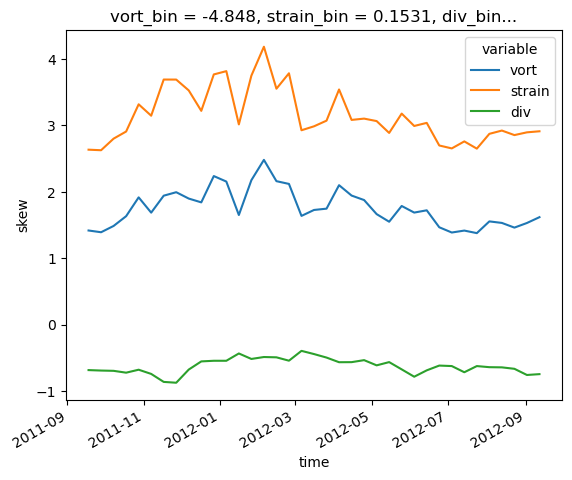

In [38]:
skew.plot(x='time', hue='variable')

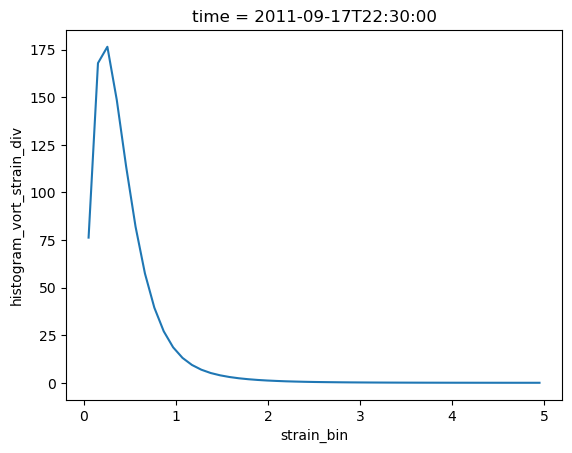

In [39]:
h.isel(time=0).sum(['vort_bin', 'div_bin']).plot()

### Kurtosis

In [40]:
kurt_vort = kurtosis(h, h.vort_bin)
kurt_strain = kurtosis(h, h.strain_bin)
kurt_div = kurtosis(h, h.div_bin)

In [41]:
kurt = xr.concat(
    [kurt_vort, kurt_strain, kurt_div], 
    dim=xr.DataArray([kurt_vort.name, kurt_strain.name, kurt_div.name], dims='variable'),
).rename('kurtosis')

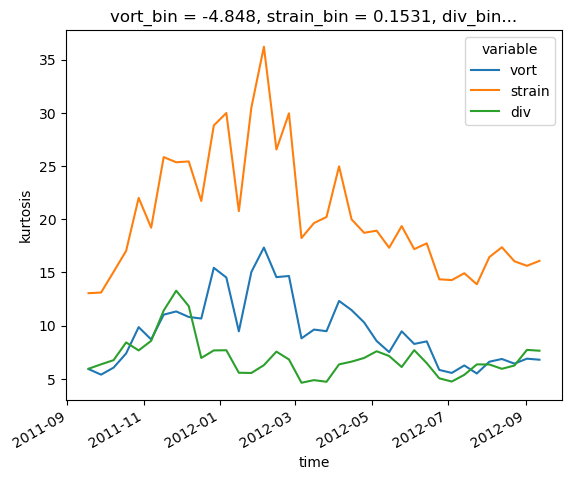

In [42]:
kurt.plot(x='time', hue='variable')

## 3D histograms

## As 3D volume

### As grids of 2D slices

In [54]:
h.isel(time=0).coarsen(div_bin=7, boundary='trim').sum('div_bin')

<xarray.DataArray 'histogram_vort_strain_div' (vort_bin: 99, strain_bin: 49,
                                               div_bin: 14)>
dask.array<sum-aggregate, shape=(99, 49, 14), dtype=float64, chunksize=(99, 49, 14), chunktype=numpy.ndarray>
Coordinates:
  * div_bin     (div_bin) float64 -4.646 -3.939 -3.232 ... 3.131 3.838 4.545
  * strain_bin  (strain_bin) float64 0.05102 0.1531 0.2551 ... 4.745 4.847 4.949
    time        datetime64[ns] 2011-09-17T22:30:00
  * vort_bin    (vort_bin) float64 -4.949 -4.848 -4.747 ... 4.747 4.848 4.949

In [56]:
h.isel(time=0).coarsen(div_bin=9, boundary='trim', coord_func={'div_bin': 'median'}).sum('div_bin')

<xarray.DataArray 'histogram_vort_strain_div' (vort_bin: 99, strain_bin: 49,
                                               div_bin: 11)>
dask.array<sum-aggregate, shape=(99, 49, 11), dtype=float64, chunksize=(99, 49, 11), chunktype=numpy.ndarray>
Coordinates:
  * div_bin     (div_bin) float64 -4.545 -3.636 -2.727 ... 2.727 3.636 4.545
  * strain_bin  (strain_bin) float64 0.05102 0.1531 0.2551 ... 4.745 4.847 4.949
    time        datetime64[ns] 2011-09-17T22:30:00
  * vort_bin    (vort_bin) float64 -4.949 -4.848 -4.747 ... 4.747 4.848 4.949

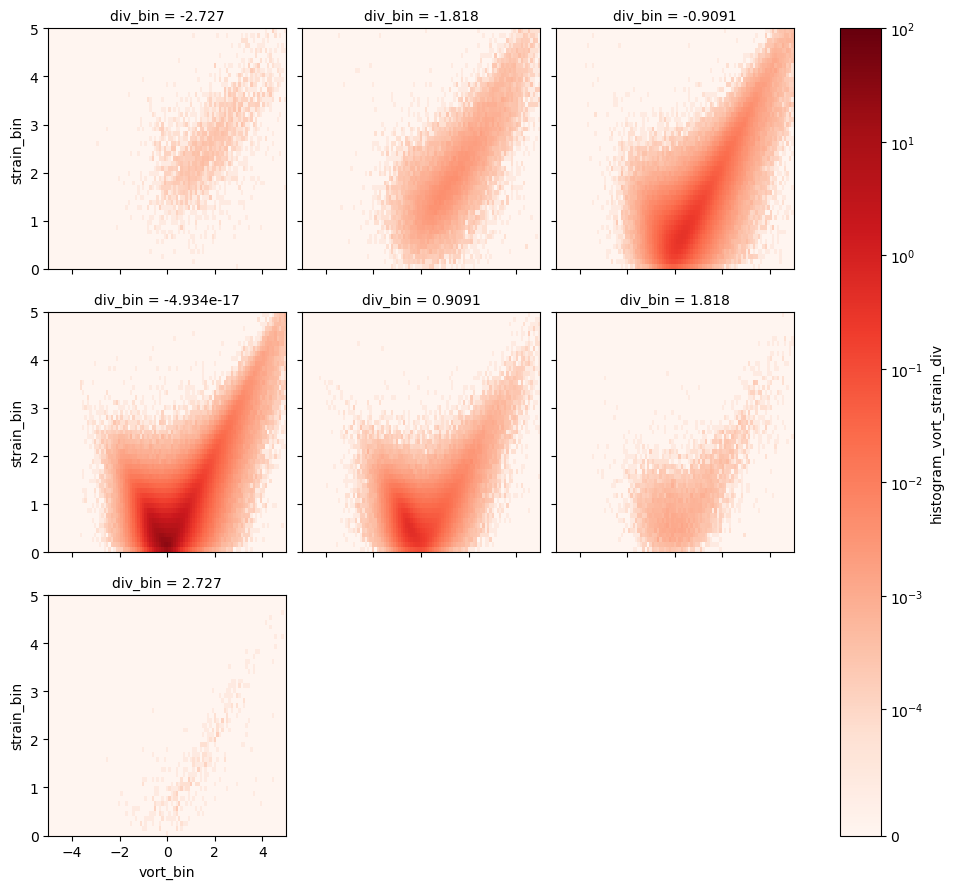

In [58]:
h.isel(time=0).coarsen(div_bin=9, boundary='trim').sum('div_bin').sel(div_bin=slice(-3, +3)).plot(
    x='vort_bin', row='div_bin', col_wrap=3, vmax=1e2, norm=mpl.colors.SymLogNorm(1e-4), cmap='Reds',
)

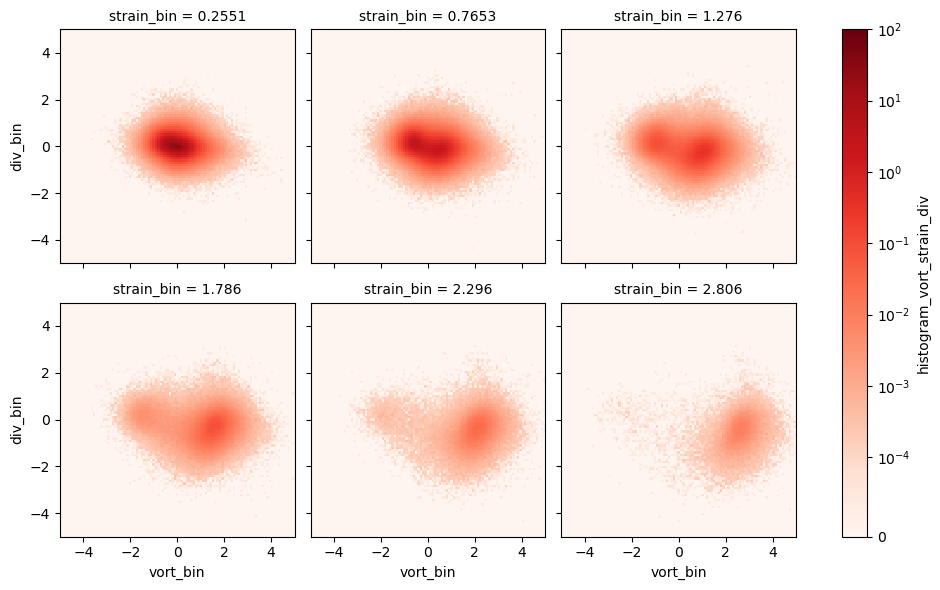

In [61]:
h.isel(time=0).coarsen(strain_bin=5, boundary='trim').sum('strain_bin').sel(strain_bin=slice(0, +3)).plot(
    x='vort_bin', row='strain_bin', col_wrap=3, vmax=1e2, norm=mpl.colors.SymLogNorm(1e-4), cmap='Reds',
)

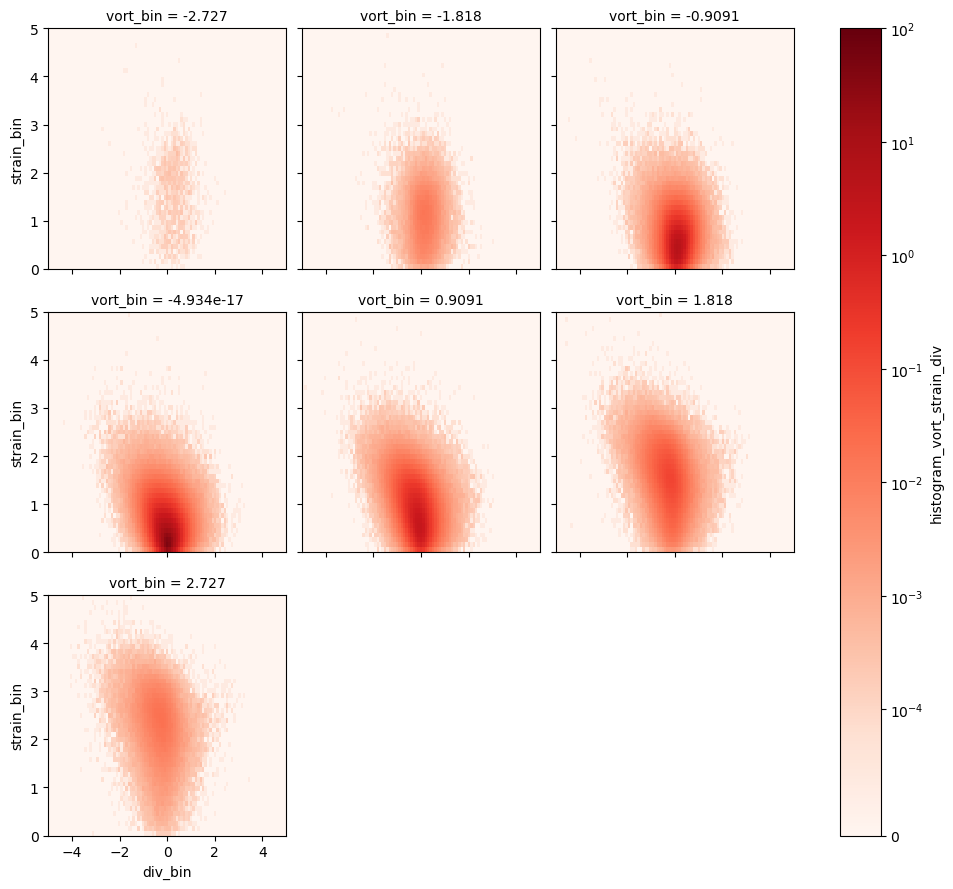

In [62]:
h.isel(time=0).coarsen(vort_bin=9, boundary='trim').sum('vort_bin').sel(vort_bin=slice(-3, +3)).plot(
    x='div_bin', row='vort_bin', col_wrap=3, vmax=1e2, norm=mpl.colors.SymLogNorm(1e-4), cmap='Reds',
)

## Conditional mean 2D histograms

Plots of the mean of one quantity conditional upon the other two.

In [68]:
def plot_vort_strain_hist_with_div(h):
    
    h = xr.where(h<1e-5, np.nan, h)  # discard values less than threshold
    
    plt.figure(figsize=(10,4.5))
    
    # find the mean divergence for each vort-strain pair
    mean_div = h['div_bin'].weighted(h.fillna(0)).mean(dim='div_bin')
    
    mean_div.plot(x="vort_bin", vmax=1.2, center=0, norm=mpl.colors.SymLogNorm(1e-1))#, cmap='Reds')
    
    # plot the lines of perfect correlation / anti-correlation
    strain_max = h.coords["strain_bin"].max()
    plt.plot(np.linspace(0, -strain_max, 10),np.linspace(0, strain_max, 10),'k--',alpha=.5)
    vort_max = h.coords["vort_bin"].max()
    plt.plot(np.linspace(0, vort_max), np.linspace(0, vort_max),'k--',alpha=.5)
    
    # labels
    plt.xlabel('vorticity / $f_0$')
    plt.ylabel('strain / $|f_0|$')
    
    plt.text(0, strain_max / 2, 'Front')
    plt.text(vort_max / 2, strain_max / 4, 'Cyc')
    plt.text(-vort_max / 2, strain_max / 4, 'Acyc')
    
    # grid
    plt.rc('grid', color='black', alpha=.3)
    plt.grid()

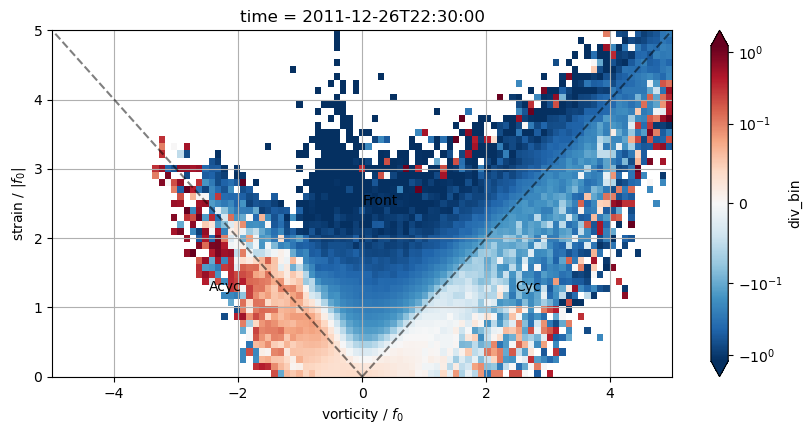

In [70]:
plot_vort_strain_hist_with_div(h.isel(time=10))

In [86]:
def plot_vort_div_hist_with_strain(h):
    
    h = xr.where(h<1e-5, np.nan, h)  # discard values less than threshold
    
    plt.figure(figsize=(10,4.5))
    
    # find the mean strain for each vort-div pair
    mean_strain = h['strain_bin'].weighted(h.fillna(0)).mean(dim='strain_bin')
    
    mean_strain.plot(x="vort_bin",vmax=2, norm=mpl.colors.LogNorm(1e-1)) #, cmap='Reds')
    
    # labels
    plt.xlabel('vorticity / $f_0$')
    plt.ylabel('divergence / $f_0$')
    
    # grid
    plt.rc('grid', color='black', alpha=.3)
    plt.grid()

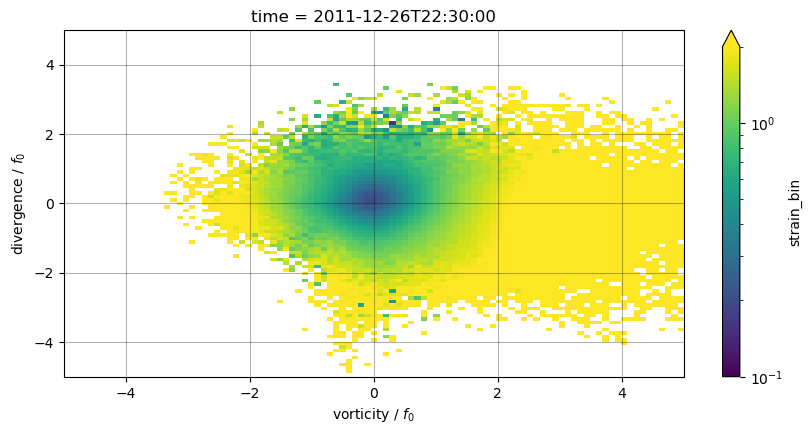

In [87]:
plot_vort_div_hist_with_strain(h.isel(time=10))

In [95]:
def plot_div_strain_hist_with_vort(h):
    
    h = xr.where(h<1e-5, np.nan, h)  # discard values less than threshold
    
    plt.figure(figsize=(10,4.5))
    
    # find the mean vort for each div-strain pair
    mean_vort = h['vort_bin'].weighted(h.fillna(0)).mean(dim='vort_bin')
    
    mean_vort.plot(x="div_bin", vmax=5.0, center=0, norm=mpl.colors.SymLogNorm(1e-1)) #, cmap='Reds')
    
    # labels
    plt.xlabel('divergence / $f_0$')
    plt.ylabel('strain / $|f_0|$')
    
    # grid
    plt.rc('grid', color='black', alpha=.3)
    plt.grid()

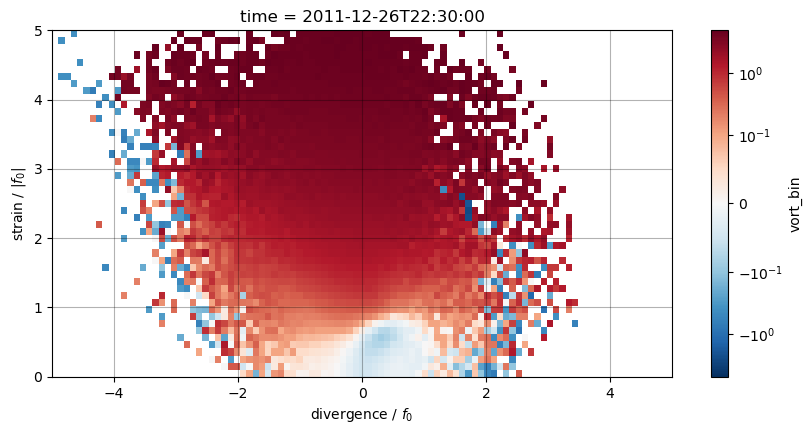

In [96]:
plot_div_strain_hist_with_vort(h.isel(time=10))

## Dhruv's comments (April 14th)

- 4-figure seasonal plots for 2D histograms
- 4 lines for seasons in line plots
- logarithmic y-axis in line plots
- "conditional mean"
- try for a different region (e.g. kuroshio)

- region selector function by lat-lon box

PCAs
- try with 3 different definitions of mean
1) .mean(region, time)
2) .mean(longitude, time)  # so keep variation with latitude only
3) .mean(time)

- Investigate variation and clustering of the means, before even looking at the PCAs